In [1]:
from pymatgen.io.lammps.outputs import parse_lammps_log
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
control_path = "monte-carlo-test/mc_batch_testing/control/"

In [3]:
# mc_thermo = parse_lammps_log("monte-carlo-test/biased_mc_test/simplified_mc.log")
mc_thermo = parse_lammps_log("monte-carlo-test/mc_batch_testing/control/simplified_mc.log")
# data_parm = parse_lammps_log("lammpsdata_test/oleic_xligand.test.log")
# lammps_mol = parse_lammps_log("lammpsmol_test/combined_mc.log")

In [4]:
len(mc_thermo)

5

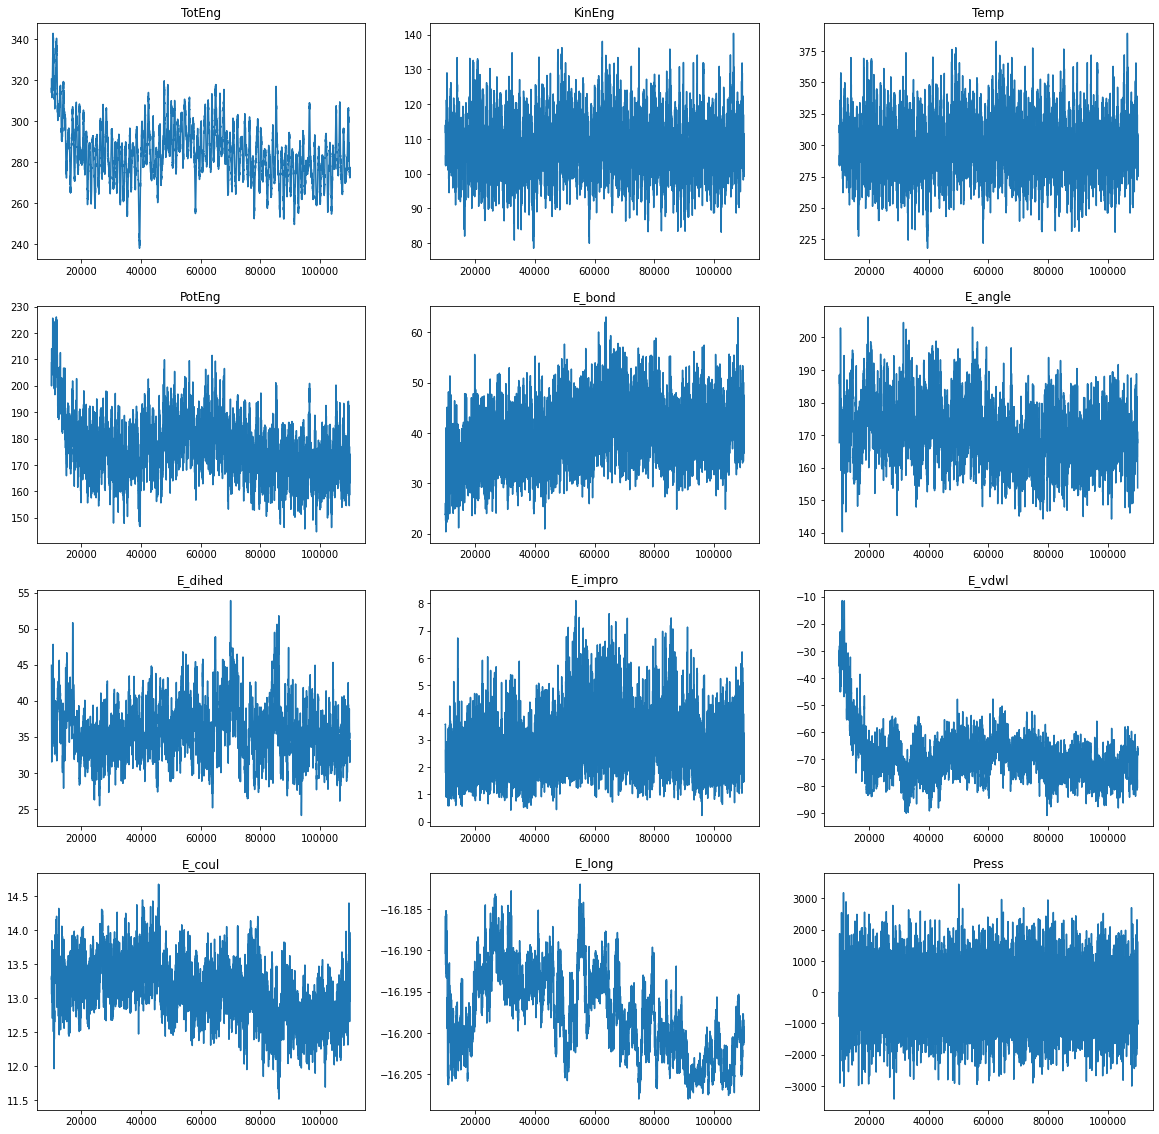

In [5]:
fig, axs = plt.subplots(4,3, figsize=(20,20))
dat = mc_thermo[4].columns[1:]
x = mc_thermo[4]['Step']

for prop,ax in zip(dat, axs.ravel()):
    ax.set_title(prop)
    ax.plot(x,mc_thermo[4][prop])
    
plt.show()

In [7]:
mc_thermo[3].columns

Index(['Step', 'TotEng', 'KinEng', 'Temp', 'PotEng', 'E_bond', 'E_angle',
       'E_dihed', 'E_impro', 'E_vdwl', 'E_coul', 'E_long', 'Press'],
      dtype='object')

In [6]:
import MDAnalysis as mda
# from MDAnalysis.tests.datafiles import PSF, DCD   # test trajectory
import numpy.linalg

In [7]:
system = mda.Universe("monte-carlo-test/struct_file/oleic_xlig.mol2", f"monte-carlo-test/mc_batch_testing/control/simplified_mc.simple_mc.lammpsdump")

In [8]:
system.trajectory

<DumpReader monte-carlo-test/mc_batch_testing/control/simplified_mc.simple_mc.lammpsdump with 10001 frames of 122 atoms>

In [9]:
xlig = system.atoms[0:68]
oleic = system.atoms[68:]

Define orientation vectors for the two molecules? This data should actually be extractable from lammps in theory since it's being controlled by the montecarlo fix...

As a proxy, define it as the vector between first and last heavy atom of the molecule?

In [21]:
xlig.radius_of_gyration()

7.117850193820992

In [22]:
xlig_vectors = []
oleic_vectors = []
rgyr_x = []
rgyr_o = []
for ts in system.trajectory:
    vector1 = xlig[-1].position - xlig[0].position
    xlig_vectors.append(vector1)
    vector2 = oleic[-1].position - oleic[0].position
    oleic_vectors.append(vector2)
    rgyr_x.append(xlig.radius_of_gyration())
    rgyr_o.append(oleic.radius_of_gyration())

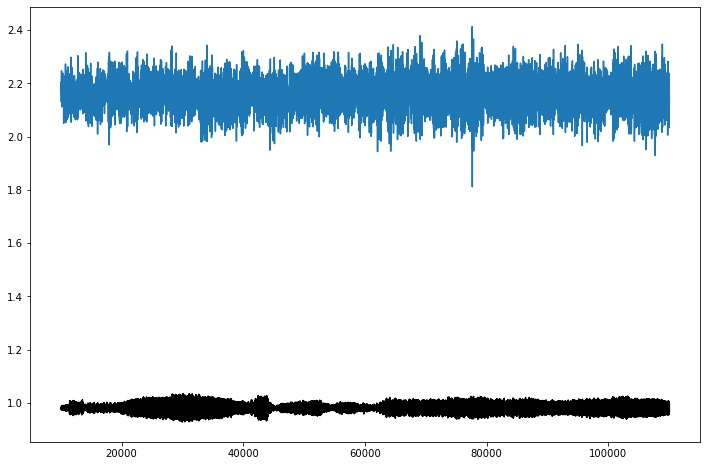

In [18]:
plt.figure(figsize=(12,8))

xlig_backbone = [np.linalg.norm(x) for x in xlig_vectors]
oleic_backbone = [np.linalg.norm(x) for x in oleic_vectors]

plt.plot(x, xlig_backbone)
plt.plot(x, oleic_backbone, color="black")
plt.show()

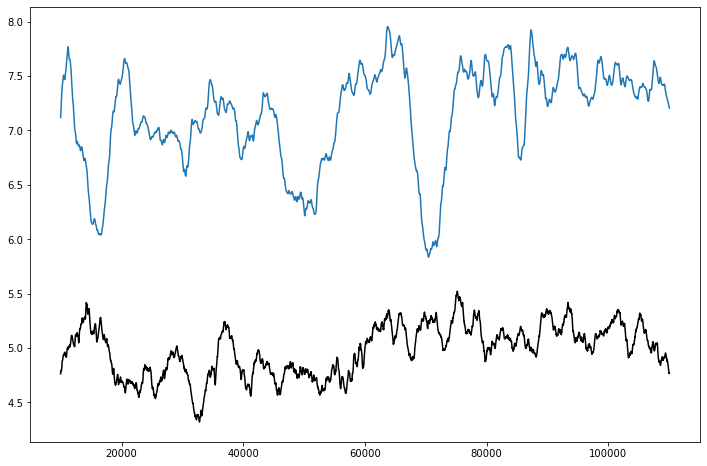

In [24]:
plt.figure(figsize=(12,8))

plt.plot(x, rgyr_x)
plt.plot(x, rgyr_o, color="black")
plt.show()

In [30]:
%%time
oleic_analysis = {
    "COM": [],
    "COG": []
}

xlig_analysis = {
    "COM": [],
    "COG": []
}

for ts in system.trajectory:
    xlig.wrap()
    oleic.wrap()
    oleic_analysis['COM'].append(oleic.center_of_mass())
    oleic_analysis['COG'].append(oleic.center_of_geometry())
    xlig_analysis['COM'].append(xlig.center_of_mass())
    xlig_analysis['COG'].append(xlig.center_of_geometry())

CPU times: user 5.62 s, sys: 63.5 ms, total: 5.69 s
Wall time: 7.11 s


In [33]:
mass_distance = [np.linalg.norm(xlig_analysis['COM'][i] - oleic_analysis['COM'][i]) for i in range(len(system.trajectory))]
geo_distance = [np.linalg.norm(xlig_analysis['COG'][i] - oleic_analysis['COG'][i]) for i in range(len(system.trajectory))]

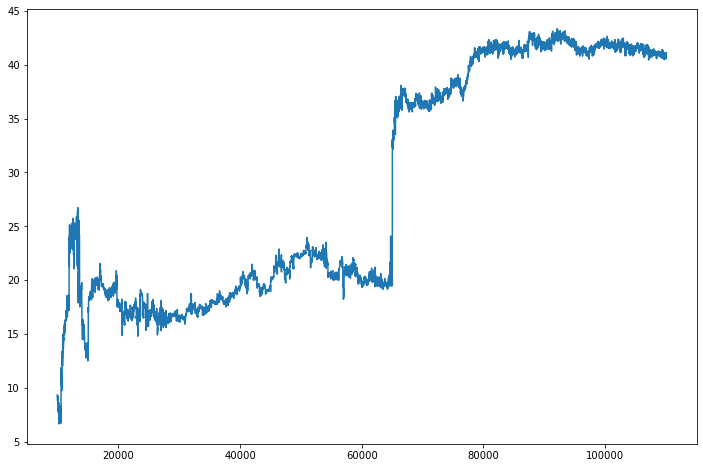

In [29]:
plt.figure(figsize=(12,8))

plt.plot(x,mass_distance)

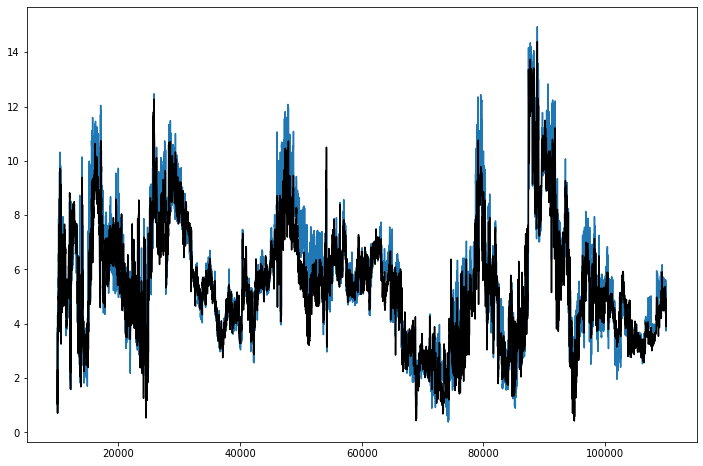

In [35]:
plt.figure(figsize=(12,8))

plt.plot(x,mass_distance)
plt.plot(x,geo_distance, color="black")
plt.show()

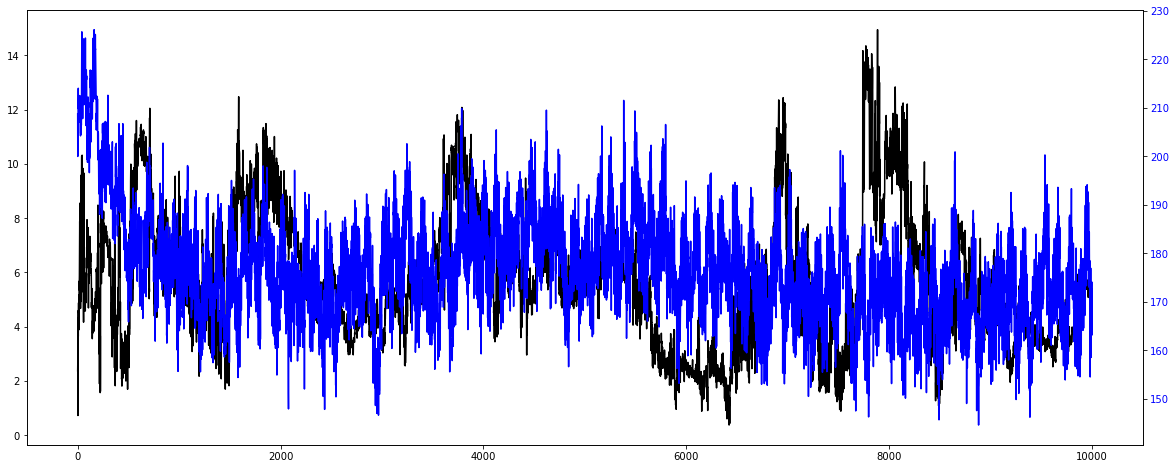

In [40]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(mass_distance, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(mc_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()

No clear correlation between COM/COGs and energy

Want to check the correlation between ring COM, oleic COM, and energy next

5-membered ring: 1-4, 31

Rings: 1-14, 27-31

In [47]:
fiver = xlig[0:4]
fiver = fiver.concatenate(xlig[30])

In [49]:
for atom in fiver:
    print(atom)

<Atom 1: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 2: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 3: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 4: N of type N.pl3 of resname UNL1, resid 1 and segid SYSTEM>
<Atom 31: C of type C.3 of resname UNL1, resid 1 and segid SYSTEM>


In [53]:
fiver_com = []

for ts in system.trajectory:
    fiver.wrap()
    fiver_com.append(fiver.center_of_mass())

In [54]:
fiver_mass_distance = [np.linalg.norm(fiver_com[i] - oleic_analysis['COM'][i]) for i in range(len(system.trajectory))]


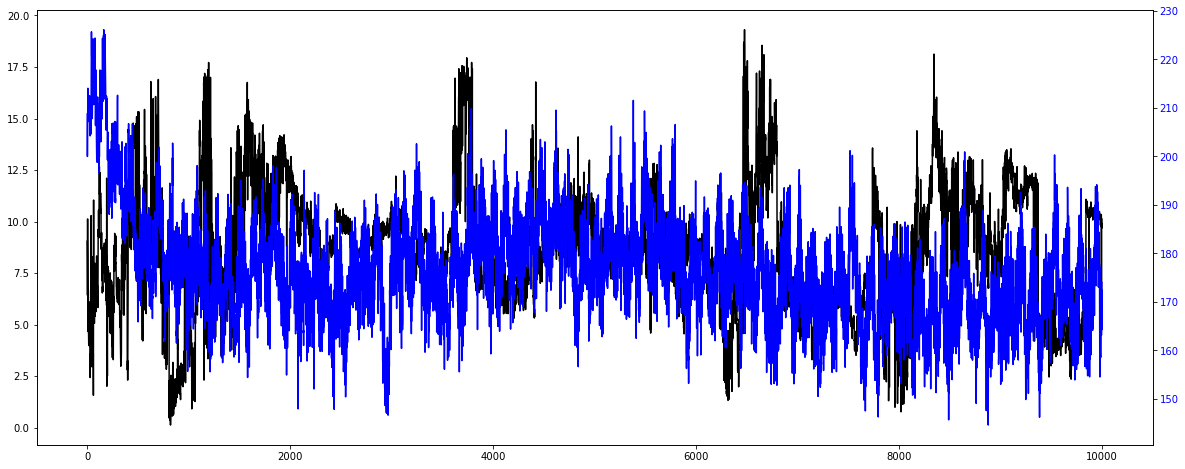

In [57]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(fiver_mass_distance, color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()

ax2.plot(mc_thermo[4]['PotEng'], color='blue')
ax2.tick_params(axis='y', labelcolor="blue")

plt.show()